## Write A Data Science Blog Post
##### by Markus Müller


Content:
- [Intrpduction](#intro)
- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Question 1: What is the availability over the year and how does the price develop?](#q1)
- [Question 2: Where are the BnBs in Boston and how expensive is each of them?](#q2)
- [Question 3: Which neighbourhoods are the most expensive?](#q3)
- [Question 4: What features influence the price of a BnB?](#q4)
- [Question 5: How does amenities impact the price?](#q5)
- [Resources](#resources)

<a id='intro'></a>
### Intorduction
This notebook is a deliverable for the Udacity Data Scientist Nanodegree and is the basis for the blog post published on Medium.


Data: Boston Airbnb Open Data from <a href='https://www.kaggle.com/airbnb/boston'>Kaggle</a>

Structure:
- listings: full descriptions and average review score
- reviews: unique id for each reviewer and detailed comments (we wont need this)
- calendar: listing id and the price and availability for that day

In [1]:
# imports
import datetime
import numpy as np
import pandas as pd
pd.set_option("max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os

import plotly.express as px
import plotly.io as pio # export plotly visualizations to HTML

from sklearn.linear_model import LinearRegression
from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [164]:
# set seaborn style to get uniform visualizations

#set base color
b_color = sns.color_palette()[0]
# set seaborn style for uniform 
sns.set_style('whitegrid')

<a id='gather'></a>
### Gather

In [3]:
# create folder
folder_name = 'Data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [4]:
# load data into DataFrames
calendar = pd.read_csv('Data/calendar.csv')
listings = pd.read_csv('Data/listings.csv')

<a id='assess'></a>
### Assess

In [5]:
calendar

listing_id        date available price
0          12147973  2017-09-05         f   NaN
1          12147973  2017-09-04         f   NaN
2          12147973  2017-09-03         f   NaN
3          12147973  2017-09-02         f   NaN
4          12147973  2017-09-01         f   NaN
...             ...         ...       ...   ...
1308885    14504422  2016-09-10         f   NaN
1308886    14504422  2016-09-09         f   NaN
1308887    14504422  2016-09-08         f   NaN
1308888    14504422  2016-09-07         f   NaN
1308889    14504422  2016-09-06         f   NaN

[1308890 rows x 4 columns]

In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [7]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

In [8]:
calendar[calendar['price'].notna()]

listing_id        date available   price
365         3075044  2017-08-22         t  $65.00
366         3075044  2017-08-21         t  $65.00
367         3075044  2017-08-20         t  $65.00
368         3075044  2017-08-19         t  $75.00
369         3075044  2017-08-18         t  $75.00
...             ...         ...       ...     ...
1308875    14504422  2016-09-20         t  $62.00
1308876    14504422  2016-09-19         t  $62.00
1308877    14504422  2016-09-18         t  $62.00
1308878    14504422  2016-09-17         t  $62.00
1308879    14504422  2016-09-16         t  $62.00

[643037 rows x 4 columns]

In [9]:
# availabe (t = True / f = False)
calendar.query('available == "f"')

listing_id        date available price
0          12147973  2017-09-05         f   NaN
1          12147973  2017-09-04         f   NaN
2          12147973  2017-09-03         f   NaN
3          12147973  2017-09-02         f   NaN
4          12147973  2017-09-01         f   NaN
...             ...         ...       ...   ...
1308885    14504422  2016-09-10         f   NaN
1308886    14504422  2016-09-09         f   NaN
1308887    14504422  2016-09-08         f   NaN
1308888    14504422  2016-09-07         f   NaN
1308889    14504422  2016-09-06         f   NaN

[665853 rows x 4 columns]

In [10]:
listings

id                            listing_url       scrape_id  \
0     12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1      3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2         6976      https://www.airbnb.com/rooms/6976  20160906204935   
3      1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4      7651065   https://www.airbnb.com/rooms/7651065  20160906204935   
...        ...                                    ...             ...   
3580   8373729   https://www.airbnb.com/rooms/8373729  20160906204935   
3581  14844274  https://www.airbnb.com/rooms/14844274  20160906204935   
3582  14585486  https://www.airbnb.com/rooms/14585486  20160906204935   
3583  14603878  https://www.airbnb.com/rooms/14603878  20160906204935   
3584  14504422  https://www.airbnb.com/rooms/14504422  20160906204935   

     last_scraped                                           name  \
0      2016-09-07                     Sunny Bungalow in the City   
1      2016-09-07              Charming room in pet friendly apt   
2      2016-09-07               Mexican Folk Art Haven in Boston   
3      2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4      2016-09-07                            Come Home to Boston   
...           ...                                            ...   
3580   2016-09-07                           Big cozy room near T   
3581   2016-09-07            BU Apartment DexterPark Bright room   
3582   2016-09-07                       Gorgeous funky apartment   
3583   2016-09-07          Great Location; Train and Restaurants   
3584   2016-09-07             (K1) Private Room near Harvard/MIT   

                                                summary  \
0     Cozy, sunny, family home.  Master bedroom high...   
1     Charming and quiet room in a second floor 1910...   
2     Come stay with a friendly, middle-aged guy in ...   
3     Come experience the comforts of home away from...   
4     My comfy, clean and relaxing home is one block...   
...                                                 ...   
3580  5 min walking to Orange Line subway with 2 sto...   
3581  Most popular apartment in BU, best located in ...   
3582  Funky little apartment close to public transpo...   
3583  My place is close to Taco Loco Mexican Grill, ...   
3584  My place is close to My home is a warm and fri...   

                                                  space  \
0     The house has an open and cozy feel at the sam...   
1     Small but cozy and quite room with a full size...   
2     Come stay with a friendly, middle-aged guy in ...   
3     Most places you find in Boston are small howev...   
4     Clean, attractive, private room, one block fro...   
...                                                 ...   
3580                                                NaN   
3581                                Best location in BU   
3582  Modern and relaxed space with many facilities ...   
3583                                                NaN   
3584  To ensure a smooth check in: 1. You MUST have ...   

                                            description experiences_offered  \
0     Cozy, sunny, family home.  Master bedroom high...                none   
1     Charming and quiet room in a second floor 1910...                none   
2     Come stay with a friendly, middle-aged guy in ...                none   
3     Come experience the comforts of home away from...                none   
4     My comfy, clean and relaxing home is one block...                none   
...                                                 ...                 ...   
3580  5 min walking to Orange Line subway with 2 sto...                none   
3581  Most popular apartment in BU, best located in ...                none   
3582  Funky little apartment close to public transpo...                none   
3583  My place is close to Taco Loco Mexican Grill, ...                none   
3584  My place is close to My h

In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [12]:
# used this cell to visually assess different columns
listings[['id', 'price', 'weekly_price', 'monthly_price', 'cleaning_fee']]

id    price weekly_price monthly_price cleaning_fee
0     12147973  $250.00          NaN           NaN       $35.00
1      3075044   $65.00      $400.00           NaN       $10.00
2         6976   $65.00      $395.00     $1,350.00          NaN
3      1436513   $75.00          NaN           NaN       $50.00
4      7651065   $79.00          NaN           NaN       $15.00
...        ...      ...          ...           ...          ...
3580   8373729   $69.00          NaN           NaN          NaN
3581  14844274  $150.00          NaN           NaN       $15.00
3582  14585486  $198.00          NaN           NaN          NaN
3583  14603878   $65.00          NaN           NaN          NaN
3584  14504422   $65.00          NaN           NaN       $25.00

[3585 rows x 5 columns]

In [13]:
# used this cell to visually assess different columns
listings[['id', 'host_since', 'first_review', 'last_review', 'neighbourhood', 'neighbourhood_cleansed', 'property_type']]

id  host_since first_review last_review neighbourhood  \
0     12147973  2015-04-15          NaN         NaN    Roslindale   
1      3075044  2012-06-07   2014-06-01  2016-08-13    Roslindale   
2         6976  2009-05-11   2009-07-19  2016-08-05    Roslindale   
3      1436513  2013-04-21   2016-08-28  2016-08-28           NaN   
4      7651065  2014-05-11   2015-08-18  2016-09-01    Roslindale   
...        ...         ...          ...         ...           ...   
3580   8373729  2014-07-31   2015-09-18  2016-08-27    Somerville   
3581  14844274  2015-07-02          NaN         NaN           NaN   
3582  14585486  2014-01-14          NaN         NaN           NaN   
3583  14603878  2016-05-27   2016-08-27  2016-09-04    Somerville   
3584  14504422  2015-08-20          NaN         NaN    Somerville   

     neighbourhood_cleansed property_type  
0                Roslindale         House  
1                Roslindale     Apartment  
2                Roslindale     Apartment  
3                Roslindale         House  
4                Roslindale         House  
...                     ...           ...  
3580            Charlestown     Apartment  
3581                Allston     Apartment  
3582            Charlestown     Apartment  
3583            Charlestown     Apartment  
3584            Charlestown     Apartment  

[3585 rows x 7 columns]

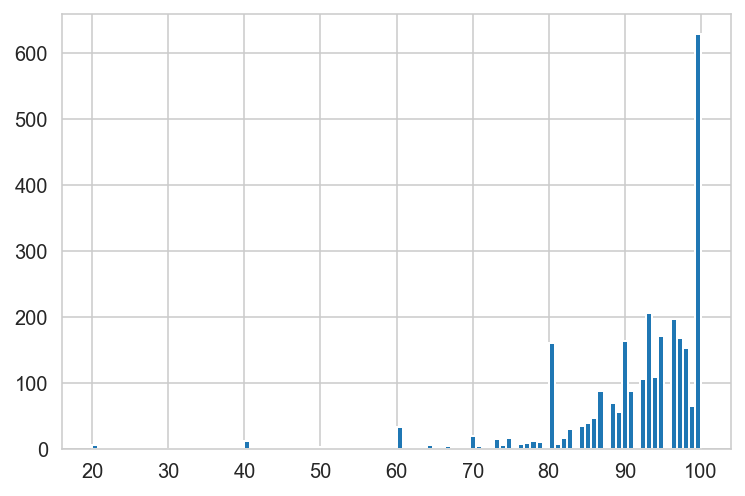

In [14]:
# check distribution of reviews
listings['review_scores_rating'].hist(bins=100);

In [15]:
listings.isnull().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   756
Length: 95, dtype: int64

#### Result Data Assessment

##### calendar
- `price` is an object 
- `date` should be a DateTimeObject

##### lisitings
- `price` in an object 
- `price` has outliers
- `host_since` should be a DateTimeObject

<a id='assess'></a>
### Data Cleaning

In [16]:
# copy DataFrames
calendar_clean = calendar.copy()
listings_clean = listings.copy()

##### clean price coloumns

In [17]:
# function to clean and transform 
def clean_price(df, p_column):
    df['price_clean'] = df[p_column].str.replace('[$,]', '')
    df['price_clean'] = df['price_clean'].astype(float)
    df.drop(columns=p_column, inplace=True)

In [18]:
# apply function
clean_price(calendar_clean, 'price')
clean_price(listings_clean, 'price')

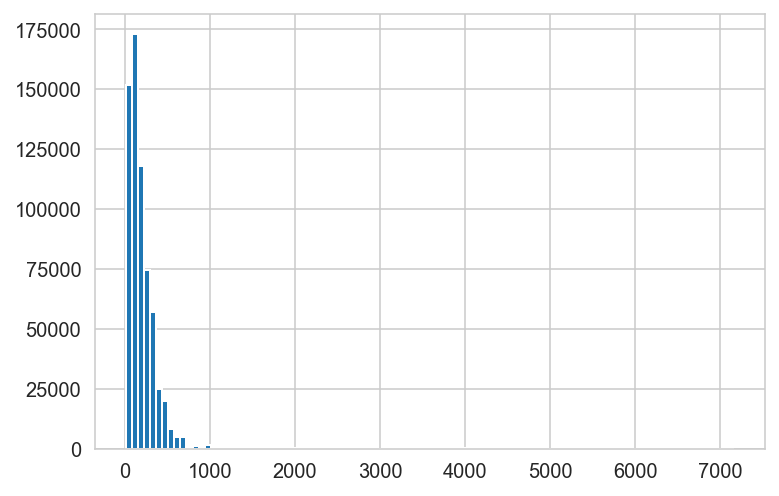

In [31]:
# check values
calendar_clean['price_clean'].hist(bins=100);

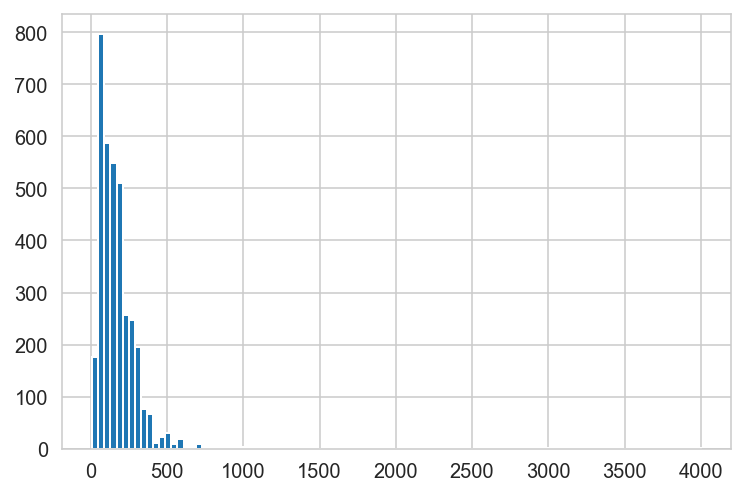

In [32]:
# check values
listings_clean['price_clean'].hist(bins=100);

##### remove outliers in price columns:
- I will remove price higher than 1000 in calendar_clean and higher than 600 in listings_clean

In [33]:
listings_clean = listings_clean.query('price_clean <= 600')

In [35]:
calendar_clean = calendar_clean.query('price_clean <= 1000')

##### transforme date to DateTimeObject and extract day of week

In [36]:
calendar_clean['date'] = pd.to_datetime(calendar_clean['date'], format='%Y-%m-%d')
listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'], format='%Y-%m-%d')

In [37]:
# get day of week from DateTimeObject
calendar_clean['day_of_week'] = calendar_clean['date'].dt.strftime('%a')

In [38]:
calendar_clean.head(5)

listing_id       date available  price_clean day_of_week
365     3075044 2017-08-22         t         65.0         Tue
366     3075044 2017-08-21         t         65.0         Mon
367     3075044 2017-08-20         t         65.0         Sun
368     3075044 2017-08-19         t         75.0         Sat
369     3075044 2017-08-18         t         75.0         Fri

<a id='q1'></a>
### Question 1: What is the availability over the year and how does the price develop?

In [39]:
# create a DataFrame for each instance
available = calendar_clean.query('available == "t"')

In [40]:
available_price = calendar_clean.query('available =="t"').groupby('date')['price_clean'].mean()

In [41]:
# grouoby date to see the availability of each day
available_plot = available.groupby('date').count()

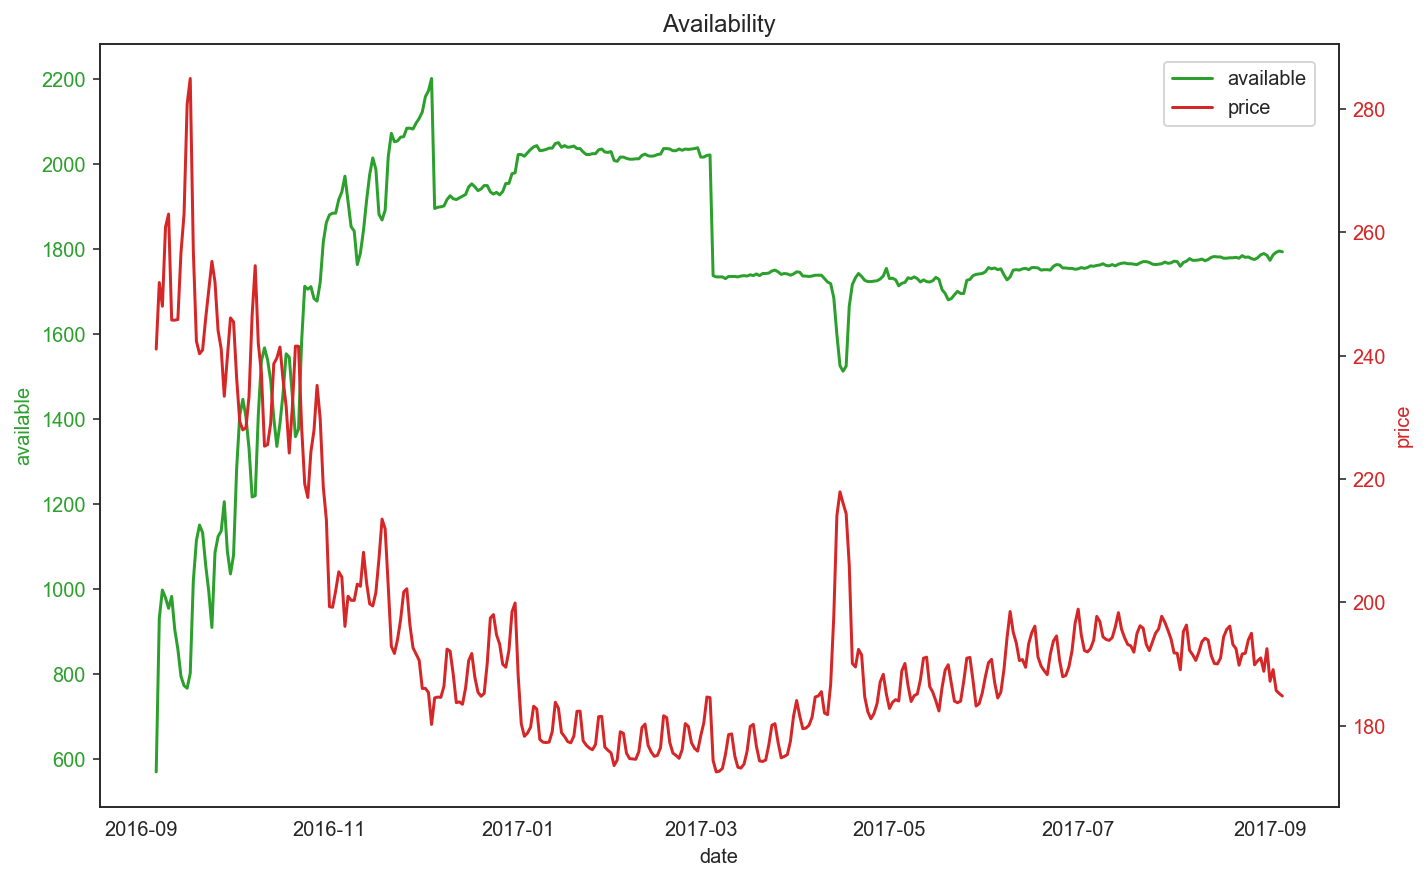

In [156]:
sns.set_style('white') # set seaborn style to remove girdlines for this visualization
fig, ax1 = plt.subplots(figsize = (10,6))

color = 'tab:green'
ax1.set_xlabel('date')
ax1.set_ylabel('available', color=color)
ax1.plot(available_plot.index, available_plot['listing_id'], label = 'available', color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax2.plot(available_price.index, available_price.values, label = 'price', color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Availability')
fig.legend(loc='upper right', bbox_to_anchor=(0.92, 0.96))
plt.savefig('Pictures/Availability.png', dpi=200, bbox_inches='tight');
# https://matplotlib.org/gallery/api/two_scales.html

- there seems to be some seasonality in the price, because it has almost the same pattern 

In [48]:
# transform to cat to polt days of week in order
available['day_of_week'] = pd.Categorical(available['day_of_week'], 
                                          categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                          ordered=True)

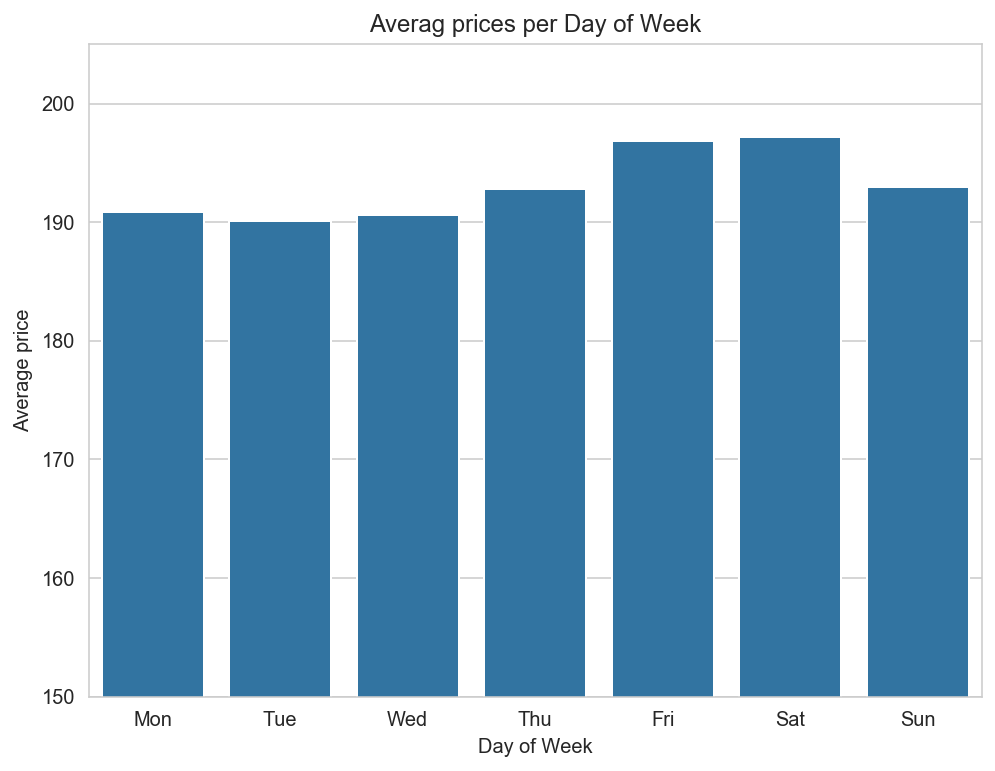

In [52]:
sns.set_style('whitegrid')
fig = plt.subplots(figsize=(8,6))
sns.barplot(x='day_of_week', y='price_clean', data=available, color=b_color, ci= None)
plt.title('Averag prices per Day of Week')
plt.ylabel('Average price')
plt.xlabel('Day of Week')
plt.ylim(150,205)
plt.savefig('Pictures/Average_prices_per_DOW.png', dpi=200);

there is a slightly higher price on Fridays and Saturdays

<a id='q2'></a>
### Question 2: Where are the BnBs in Boston and how expensive are each of them?

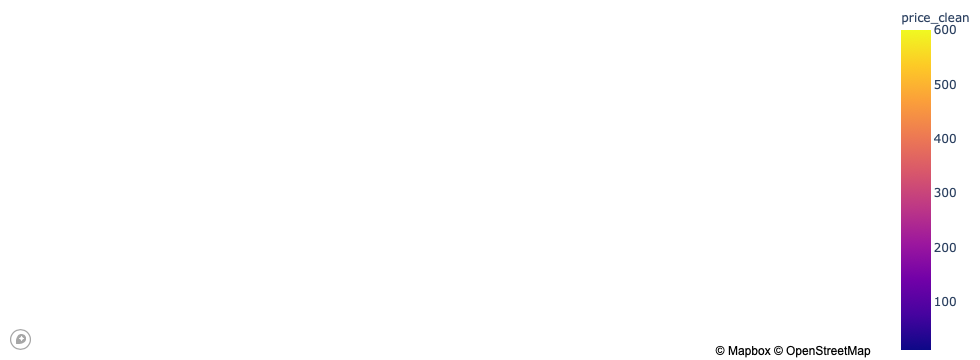

In [53]:
token = 'pk.eyJ1IjoibWFya2luZ2VyIiwiYSI6ImNrYXAzc2poOTBqc2gydXFudWdxeDAzb3kifQ._su7Ef8qqFBHuXa3tR1w9Q'
fig = px.scatter_mapbox(listings_clean, lat='latitude', lon="longitude", 
                        hover_data=['price_clean', 'neighbourhood_cleansed'],
                        color='price_clean', zoom=10, height=300,
                        #color_continuous_scale=px.colors.cyclical.IceFire)
                       )
fig.update_layout(mapbox_style='light', mapbox_accesstoken=token)
fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
fig.show()
# https://plotly.com/python/mapbox-layers/
# saves the output as HTML to use it in the Blog article
pio.write_html(fig, file='index.html', auto_open=True)
# https://towardsdatascience.com/how-to-create-a-plotly-visualization-and-embed-it-on-websites-517c1a78568b

<a id='q3'></a>
### Question 3: Which neighbourhoods are the most expensive?

In [54]:
neighbourhoods = listings_clean[['id', 'neighbourhood', 'neighbourhood_cleansed', 'price_clean']]

In [55]:
neighbourhoods['neighbourhood_cleansed'].nunique()

25

In [56]:
neighbourhoods['neighbourhood_cleansed'].value_counts()

Jamaica Plain              341
South End                  322
Back Bay                   298
Fenway                     283
Dorchester                 269
Allston                    260
Beacon Hill                187
Brighton                   184
Downtown                   172
South Boston               171
East Boston                150
North End                  143
Roxbury                    141
Mission Hill               123
Charlestown                109
South Boston Waterfront     79
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Mattapan                    24
Bay Village                 24
Longwood Medical Area        9
Leather District             5
Name: neighbourhood_cleansed, dtype: int64

In [57]:
neighbourhoods.groupby('neighbourhood_cleansed')['price_clean'].mean().sort_values(ascending = False)

neighbourhood_cleansed
Bay Village                266.833333
Leather District           253.600000
South Boston Waterfront    252.493671
Downtown                   236.459302
Chinatown                  232.352113
Back Bay                   232.040268
West End                   209.591837
Beacon Hill                199.486631
South End                  196.173913
North End                  195.678322
Fenway                     192.975265
Charlestown                186.266055
South Boston               176.865497
Longwood Medical Area      138.444444
Jamaica Plain              134.964809
Roxbury                    130.475177
East Boston                119.153333
Mission Hill               115.869919
Brighton                   113.983696
Allston                    112.307692
West Roxbury               107.108696
Roslindale                  98.428571
Dorchester                  91.639405
Hyde Park                   86.548387
Mattapan                    75.125000
Name: price_clean, dtype: f

In [58]:
neighbourhoods.groupby('neighbourhood_cleansed')['price_clean'].max().sort_values(ascending = False).head(5)

neighbourhood_cleansed
South End                  600.0
South Boston Waterfront    600.0
Back Bay                   600.0
Beacon Hill                600.0
Charlestown                600.0
Name: price_clean, dtype: float64

In [59]:
neighbourhoods['price_clean'].mean()

165.02903862418947

In [60]:
neighbourhoods['diff_to_mean'] = neighbourhoods['price_clean'] - neighbourhoods['price_clean'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



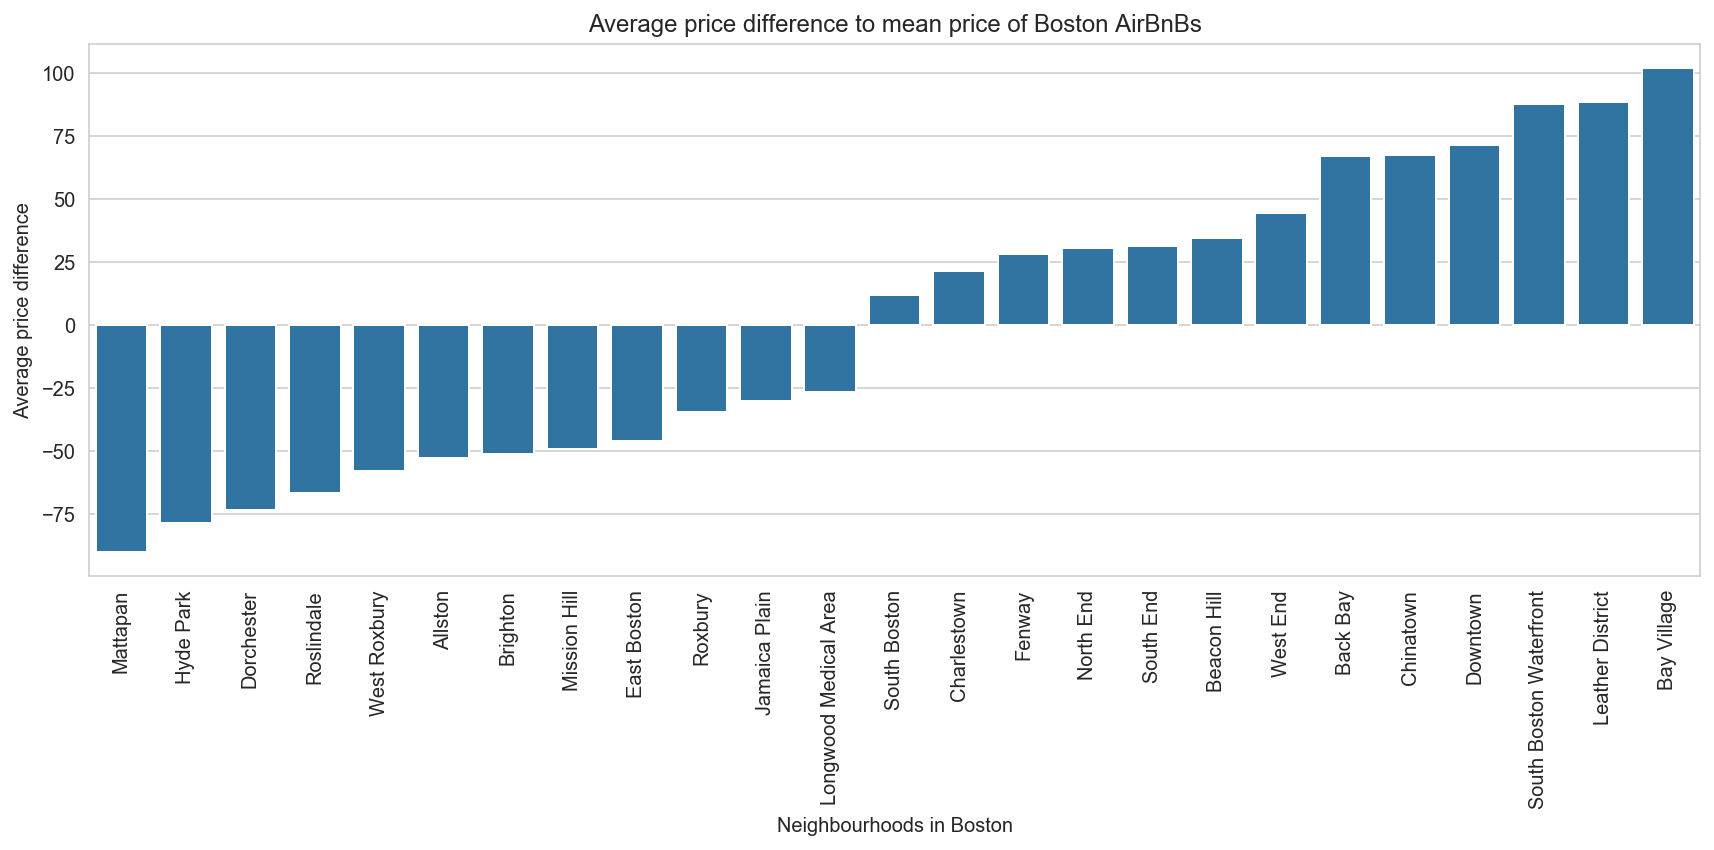

In [70]:
fig = plt.subplots(figsize=(12,6))
sns.barplot(x='neighbourhood_cleansed', y='diff_to_mean', data=neighbourhoods, 
            order=neighbourhoods.groupby('neighbourhood_cleansed')['diff_to_mean'].mean().sort_values().index,
            ci= None, color=b_color)
#plt.xticks(rotation=90)
plt.title('Average price difference to mean price of Boston AirBnBs')
plt.xlabel('Neighbourhoods in Boston')
plt.ylabel('Average price difference')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('Pictures/Neighbourhood_average_prices.png', dpi=200);

<a id='q4'></a>
### Question 4: What features influnece the price of a BnB?

In [71]:
#create a DataFrame which contains possible variables influencing price 
model = listings_clean[['id', 'bedrooms', 'beds', 'bed_type', 'room_type','bathrooms', 'property_type', 
                        'neighbourhood_cleansed', 'cancellation_policy', 'number_of_reviews',
                        'review_scores_rating', 'reviews_per_month', 'host_is_superhost', 'amenities',
                        'guests_included', 'square_feet', 'price_clean']]

In [72]:
model.isnull().sum()

id                           0
bedrooms                    10
beds                         9
bed_type                     0
room_type                    0
bathrooms                   14
property_type                3
neighbourhood_cleansed       0
cancellation_policy          0
number_of_reviews            0
review_scores_rating       798
reviews_per_month          742
host_is_superhost            0
amenities                    0
guests_included              0
square_feet               3492
price_clean                  0
dtype: int64

In [73]:
model['bedrooms'].value_counts()

1.0    2367
2.0     684
0.0     287
3.0     147
4.0      39
5.0      13
Name: bedrooms, dtype: int64

In [74]:
model['beds'].corr(model['bedrooms'])

0.6975409285801463

In [75]:
model['bathrooms'].mean()#.value_counts()

1.2135578828191338

In [76]:
model['property_type'].value_counts()

Apartment          2586
House               554
Condominium         228
Townhouse            53
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

In [77]:
model['review_scores_rating'].median()

94.0

In [78]:
model['reviews_per_month'].value_counts()

1.00    114
2.00     53
0.08     28
3.00     26
0.09     26
       ... 
6.96      1
5.83      1
6.13      1
4.95      1
4.89      1
Name: reviews_per_month, Length: 644, dtype: int64

How to handle missing values:
- `square_feet` gets droped, because it has to many missing values
- `bedrooms`: since the mean is 1.24 and mode is 1, all missing values will get filled with 1
- `beds`: gets droped -> correlates with bedrooms
- `bathrooms`: since the mean is 1.21 and the mode is 1, all missing values will get filled with 1
- `property_type`: the three missing ones will be added to other
- `review_scores_rating`: because there is no pattern behind the missing value I will use the random sample method
- `reviews_per_month`: random sample method

more methods: https://towardsdatascience.com/8-clutch-ways-to-impute-missing-data-690481c6cb2b

##### fill missing values

In [79]:
# drop square_feet and beds
model.drop(columns=['square_feet', 'beds'], inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
# bedrooms and bathrooms fill missing values with 1
model['bedrooms'] = model['bedrooms'].fillna(value=1)
model['bathrooms'] = model['bathrooms'].fillna(value=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
# change property_type 
model['property_type'] = model['property_type'].fillna(value='Other')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
#  https://stackoverflow.com/questions/36413314/filling-missing-data-by-random-choosing-from-non-missing-values-in-pandas-datafr
def fill_with_random(df2, column):
    '''Fill `df2`'s column with name `column` with random data based on non-NaN data from `column`'''
    df = df2.copy()
    df[column] = df[column].apply(lambda x: np.random.choice(df[column].dropna().values) if np.isnan(x) else x)
    return df

In [83]:
model = fill_with_random(model, 'review_scores_rating')
model = fill_with_random(model, 'reviews_per_month')

In [84]:
# check for missing values
model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 3584
Data columns (total 15 columns):
id                        3547 non-null int64
bedrooms                  3547 non-null float64
bed_type                  3547 non-null object
room_type                 3547 non-null object
bathrooms                 3547 non-null float64
property_type             3547 non-null object
neighbourhood_cleansed    3547 non-null object
cancellation_policy       3547 non-null object
number_of_reviews         3547 non-null int64
review_scores_rating      3547 non-null float64
reviews_per_month         3547 non-null float64
host_is_superhost         3547 non-null object
amenities                 3547 non-null object
guests_included           3547 non-null int64
price_clean               3547 non-null float64
dtypes: float64(5), int64(3), object(7)
memory usage: 443.4+ KB


##### identify relevant columns
- correlation matrix for numeric variables
- boxplots for categorical variables

In [85]:
#colums which could be ralated to the price 
price_corr = model[['price_clean', 'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 
                   'guests_included']]

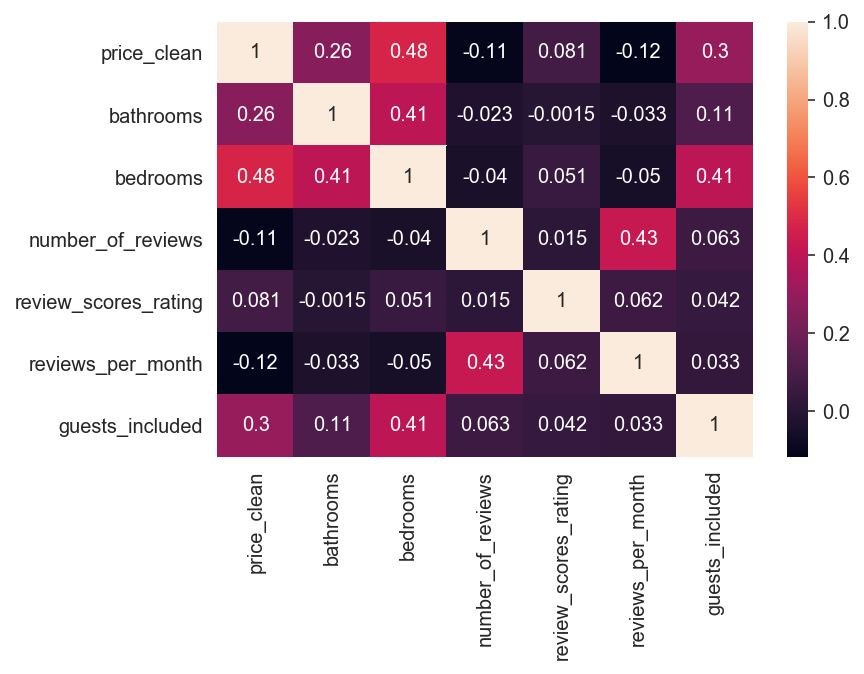

In [86]:
# create heatmap which shows the corrleation matrix
sns.heatmap(price_corr.corr(), annot=True);

There are some medium correlations for `bathrooms`, `bedrooms` and `gusts_included`. There are also very small correlations for `number of reviews` and `reviews per month`. Intersting is that the review score isn't corrleated with price.

In [87]:
# lets check the mean price distribution for the reveiw scores
score = model.groupby('review_scores_rating')['price_clean'].mean().index
mean_price = model.groupby('review_scores_rating')['price_clean'].mean().values

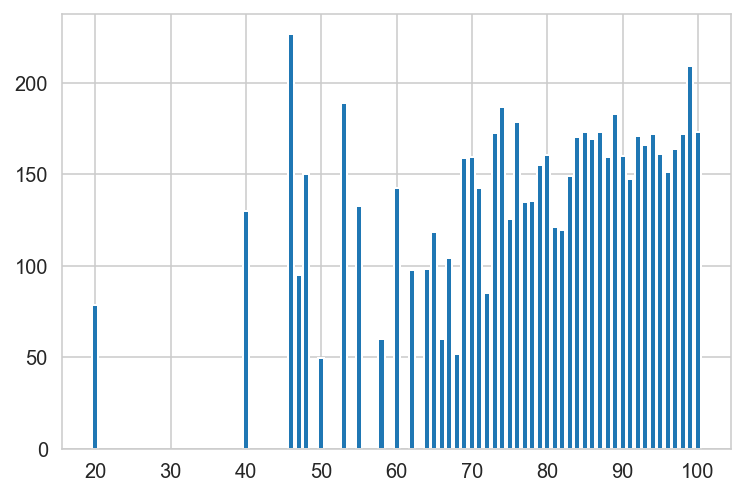

In [88]:
plt.bar(x=score, height=mean_price);

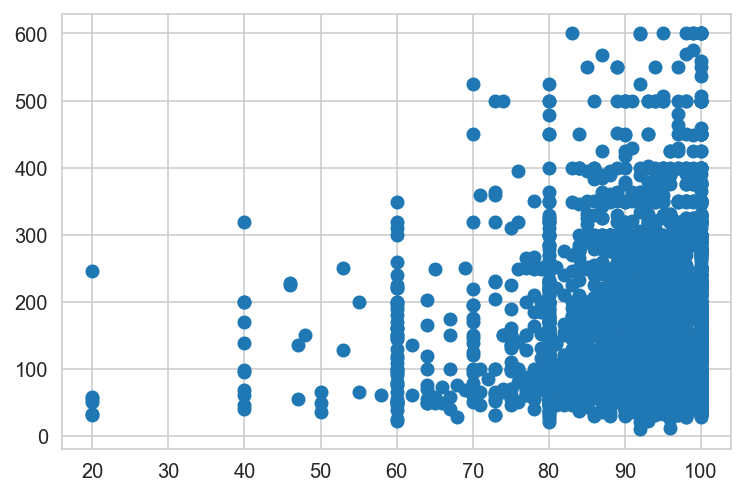

In [89]:
plt.scatter(x=model['review_scores_rating'], y=model['price_clean']);

There is no linearity between review score and price.

##### Let us now explore the relationship between price and the categorical variables

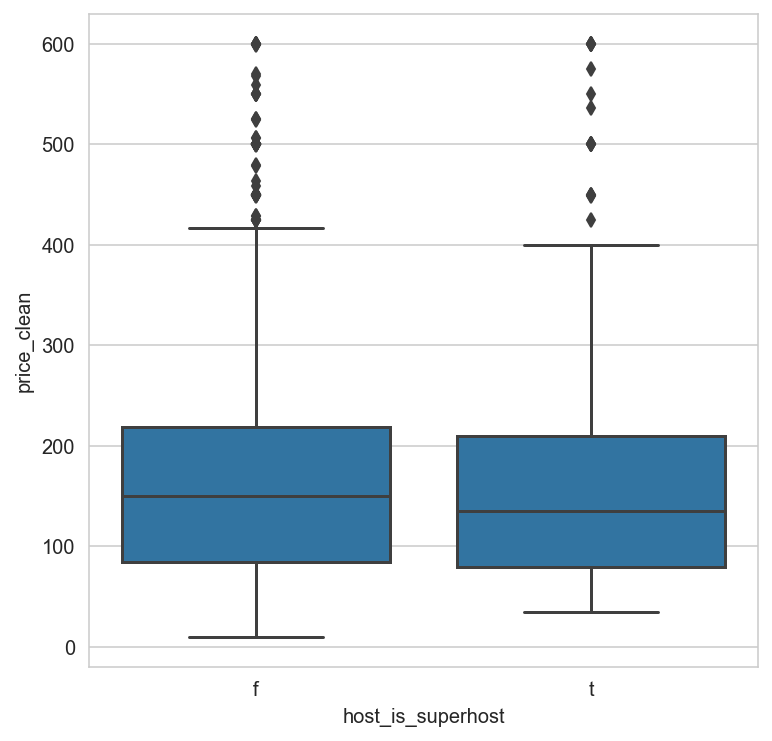

In [90]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='host_is_superhost', y='price_clean', data=listings_clean, color=b_color);

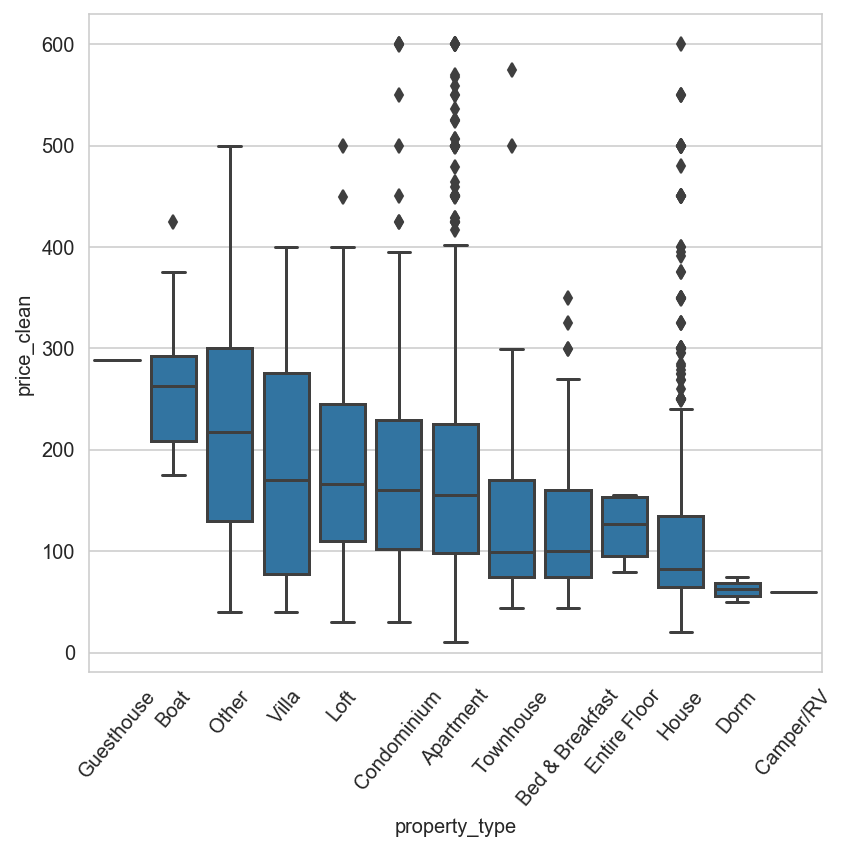

In [91]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='property_type', y='price_clean', data=listings_clean, 
            order=listings_clean.groupby('property_type')['price_clean'].mean().sort_values(ascending=False).index, 
            color=b_color)
plt.xticks(rotation=50)
plt.tight_layout();

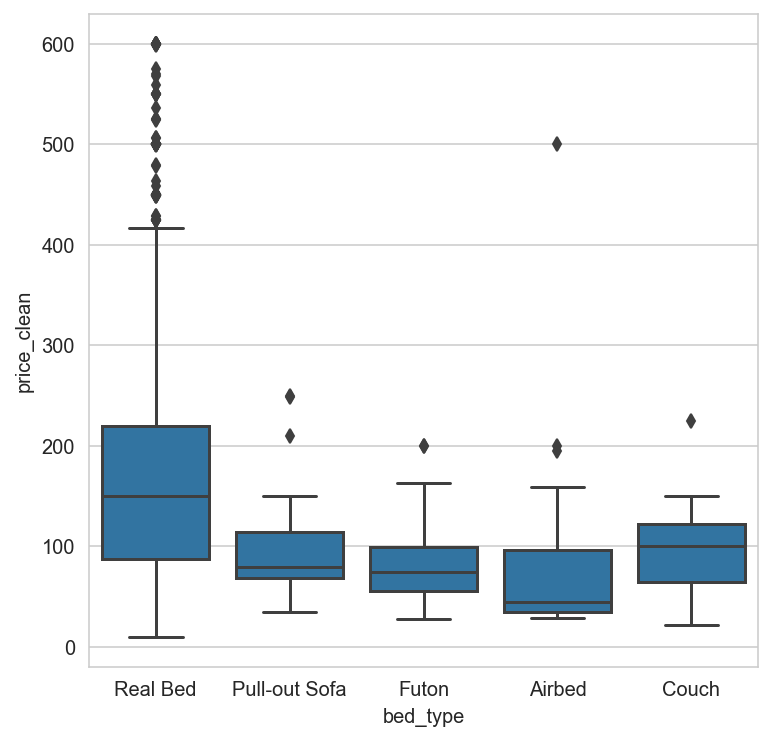

In [92]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='bed_type', y='price_clean', data=listings_clean, color=b_color);

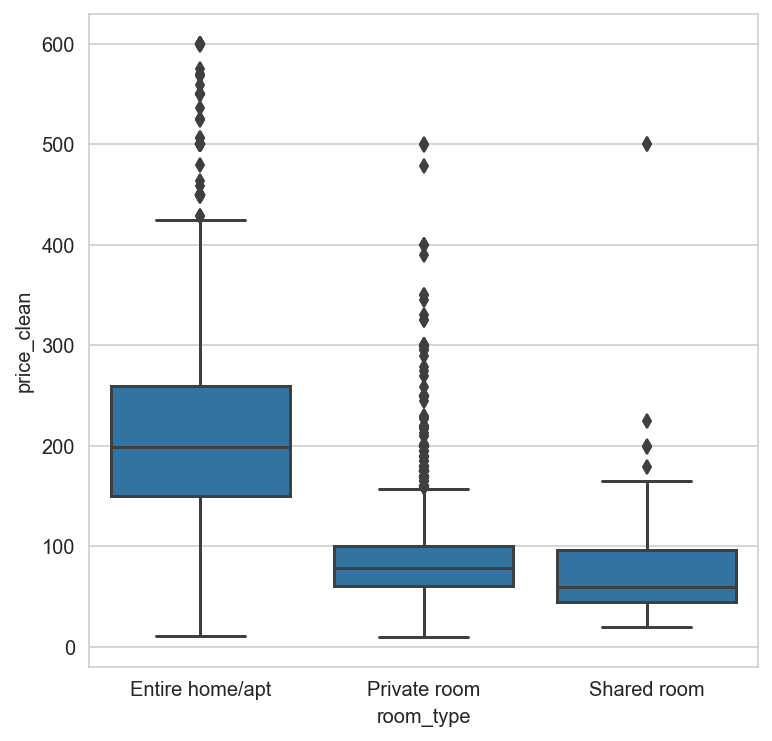

In [93]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='room_type', y='price_clean', data=listings_clean, color=b_color);

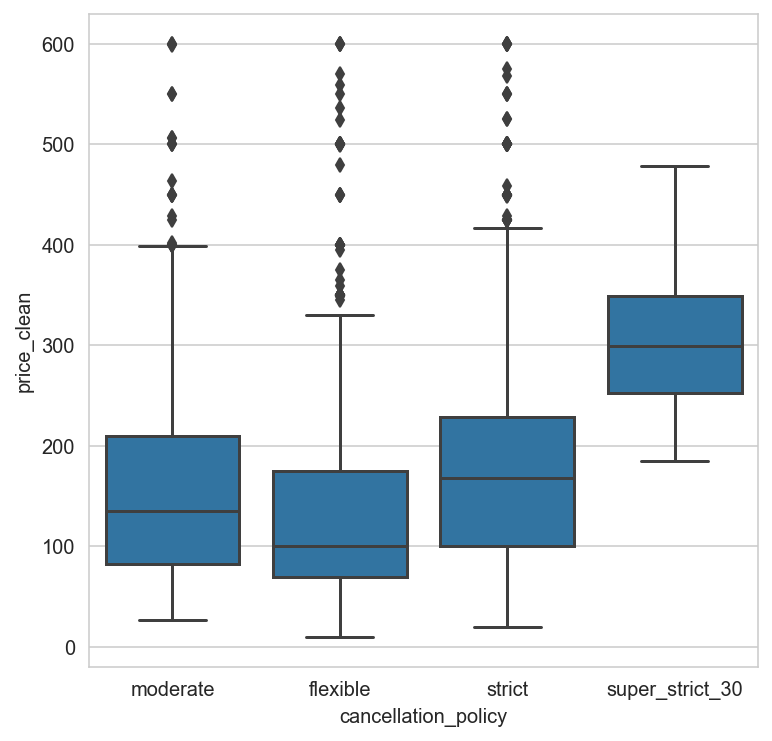

In [94]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='cancellation_policy', y='price_clean', data=listings_clean, color=b_color);

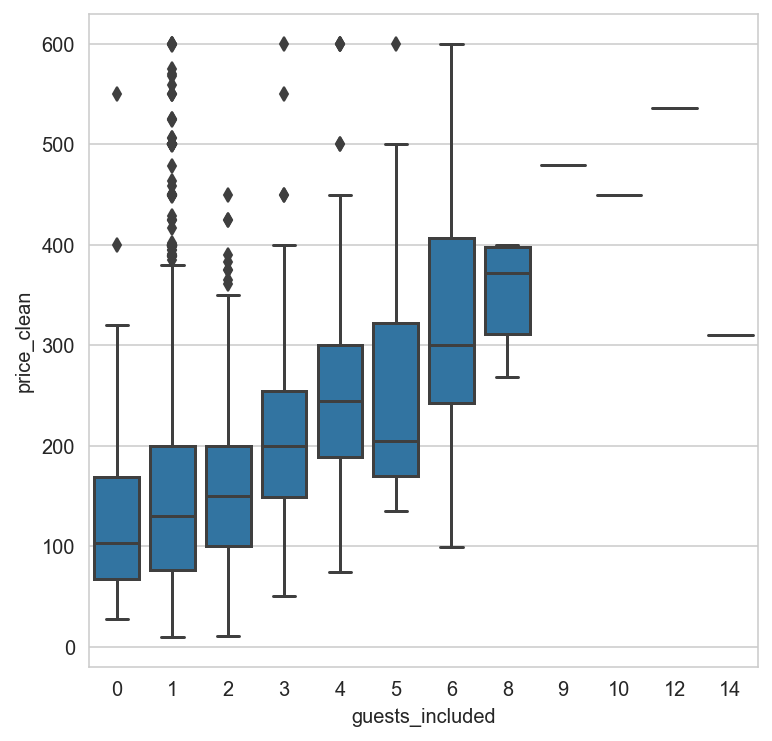

In [95]:
fig = plt.subplots(figsize=(6,6))
sns.boxplot(x='guests_included', y='price_clean', data=listings_clean, color=b_color);

#### Linear Regression to see what impacts price
evaluation of the features
- `neighbourhood_cleansed`: showed a lot of variance between different neighbourhoods (will be included)
- `bathrooms`, `bedromms` and `guests_included`: each had medium correlations with price (will be included)
- `review_scores_rating` hadn't a high correlation and the visual assesment didn't show an obvious pattern (won't be included)
- `square_feet` would be interesting, but there are to many missing values (won't be included)
- `property_type`: showed differences in mean price between different types (will be included)
- `host_is_superhost`: no difference in mean price, iff a host is or isn't a Superhost (won't be included)
- `cancalation_policy`: showed differences in mean price between different policies (will be included)
- `room_type`: showed differences in mean price between different types (will be included)
- `bed_type`: showed differences in mean price between different types (will be included)
- `amenities`: wasn't capable to show impact on price but, it is logical that different amenities are impacting the price 

To do a linear regression we need to make some transformations:
- drop unrelevant columns 
-`price` is skwed so it should be transformed but then it the oiutput from the regression looses its interpretability, so I won't transform price
- `property_type`: unpopular types will be summarized as other
- `guests_included`: combine 7 and more into one category 
- `amenities`: needs some preprocesssing
- categorical columns like: `neighbourhood_cleansed`, `bathrooms`, `cancellation_policy`, `bedrooms`, `property_type` need to be transformed to dummy variables
- create `x` and `Y` DataFrames 
- split data

##### drop unrelevant columns 

In [96]:
model.columns

Index(['id', 'bedrooms', 'bed_type', 'room_type', 'bathrooms', 'property_type',
       'neighbourhood_cleansed', 'cancellation_policy', 'number_of_reviews',
       'review_scores_rating', 'reviews_per_month', 'host_is_superhost',
       'amenities', 'guests_included', 'price_clean'],
      dtype='object')

In [97]:
model.drop(columns=['review_scores_rating', 'host_is_superhost', 'id'], inplace=True)

##### transform unpopular types to Other

In [98]:
model['property_type'].value_counts()
# everything samller as Other will be included in Other

Apartment          2586
House               554
Condominium         228
Townhouse            53
Bed & Breakfast      41
Loft                 39
Other                20
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Camper/RV             1
Guesthouse            1
Name: property_type, dtype: int64

In [99]:
types = ['Boat', 'Villa', 'Entire Floor', 'Dorm', 'Camper/RV', 'Guesthouse']
for ptype in types:
    model['property_type'] = np.where(model['property_type'] == ptype, 
                                               'Other', model['property_type'])

In [100]:
model['property_type'].value_counts()

Apartment          2586
House               554
Condominium         228
Townhouse            53
Other                46
Bed & Breakfast      41
Loft                 39
Name: property_type, dtype: int64

##### guests included: combine 7 and more into one category

In [101]:
values = [7, 8, 9, 10, 11, 12, 14]
for x in values:
    model['guests_included'] = np.where(model['guests_included'] == x, 
                                                 7, model['guests_included'])

In [102]:
model['guests_included'].value_counts()

1    2578
2     552
4     167
3      91
0      87
6      36
5      26
7      10
Name: guests_included, dtype: int64

##### amenities

In [103]:
model['amenities'].head(2)

0    {TV,"Wireless Internet",Kitchen,"Free Parking ...
1    {TV,Internet,"Wireless Internet","Air Conditio...
Name: amenities, dtype: object

In [104]:
# remove {}
model['amenities'] = model['amenities'].str.replace("[{}]", "")

In [105]:
# get dummies
amenity_dummy = model['amenities'].str.get_dummies(sep = ",")

In [106]:
# drop 'translation missing' amenities
amenity_dummy.drop(columns=['"translation missing: en.hosting_amenity_49"', '"translation missing: en.hosting_amenity_50"'], inplace=True)

In [107]:
# remove double quots from columns names
amenity_dummy.columns = amenity_dummy.columns.str.replace('"','')

In [108]:
amenity_dummy.head(2)

24-Hour Check-in  Air Conditioning  Buzzer/Wireless Intercom  Cable TV  \
0                 0                 0                         0         0   
1                 0                 1                         0         0   

   Carbon Monoxide Detector  Elevator in Building  Family/Kid Friendly  \
0                         0                     0                    1   
1                         1                     0                    1   

   Fire Extinguisher  First Aid Kit  Free Parking on Premises  \
0                  1              0                         1   
1                  1              0                         0   

   Free Parking on Street  Hair Dryer  Hot Tub  Indoor Fireplace  \
0                       0           0        0                 0   
1                       0           1        0                 0   

   Laptop Friendly Workspace  Lock on Bedroom Door  Other pet(s)  \
0                          1                     0             0   
1                          0                     1             0   

   Paid Parking Off Premises  Pets Allowed  Pets live on this property  \
0                          0             0                           1   
1                          0             1                           1   

   Safety Card  Smoke Detector  Smoking Allowed  Suitable for Events  \
0            0               1                0                    0   
1            0               1                0                    0   

   Washer / Dryer  Wheelchair Accessible  Wireless Internet  Breakfast  \
0               0                      0                  1          0   
1               0                      0                  1          0   

   Cat(s)  Dog(s)  Doorman  Dryer  Essentials  Gym  Hangers  Heating  \
0       0       1        0      1           1    0        0        1   
1       0       1        0      1           1    0        1        1   

   Internet  Iron  Kitchen  Pool  Shampoo  TV  Washer  
0         0     0        1     0        1   1       1  
1         1     1        1     0        1   1       1

In [109]:
# lets check how often individual amenities are included
amenity_dummy.sum()

24-Hour Check-in              1232
Air Conditioning              2785
Buzzer/Wireless Intercom       825
Cable TV                      1747
Carbon Monoxide Detector      2414
Elevator in Building           854
Family/Kid Friendly           1860
Fire Extinguisher             1561
First Aid Kit                 1049
Free Parking on Premises       824
Free Parking on Street           9
Hair Dryer                    1791
Hot Tub                        165
Indoor Fireplace               385
Laptop Friendly Workspace     1814
Lock on Bedroom Door           471
Other pet(s)                    16
Paid Parking Off Premises        4
Pets Allowed                   478
Pets live on this property     423
Safety Card                    453
Smoke Detector                2880
Smoking Allowed                 94
Suitable for Events            136
Washer / Dryer                   1
Wheelchair Accessible          148
Wireless Internet             3385
Breakfast                      314
Cat(s)              

It seems that some amenities are offered very rarely(<10), like: Free Parking on Street(9), Paid Parking Off Premises(4) and Washer / Dryer (1). I will drop those columns 

In [110]:
amenity_dummy.drop(columns=['Free Parking on Street', 'Paid Parking Off Premises', 'Washer / Dryer'], inplace=True)

##### create dummy variables for every categorical feature

In [111]:
model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 3584
Data columns (total 12 columns):
bedrooms                  3547 non-null float64
bed_type                  3547 non-null object
room_type                 3547 non-null object
bathrooms                 3547 non-null float64
property_type             3547 non-null object
neighbourhood_cleansed    3547 non-null object
cancellation_policy       3547 non-null object
number_of_reviews         3547 non-null int64
reviews_per_month         3547 non-null float64
amenities                 3547 non-null object
guests_included           3547 non-null int64
price_clean               3547 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 360.2+ KB


In [112]:
model_cat = model.select_dtypes(include='object')
# drop amenities since we allready created the dummy variables
model_cat.drop(columns='amenities', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
model_cat_dummy = pd.get_dummies(model_cat, drop_first=True)

In [114]:
model_cat_dummy = model_cat_dummy.astype('int64')

##### concat everything

In [115]:
model_all = pd.concat([model.select_dtypes(include=['float64', 'int64']), model_cat_dummy, amenity_dummy], axis=1)

In [116]:
model_all.head(2)

bedrooms  bathrooms  number_of_reviews  reviews_per_month  guests_included  \
0       2.0        1.5                  0               0.52                1   
1       1.0        1.0                 36               1.30                0   

   price_clean  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  \
0        250.0               0               0                       0   
1         65.0               0               0                       0   

   bed_type_Real Bed  room_type_Private room  room_type_Shared room  \
0                  1                       0                      0   
1                  1                       1                      0   

   property_type_Bed & Breakfast  property_type_Condominium  \
0                              0                          0   
1                              0                          0   

   property_type_House  property_type_Loft  property_type_Other  \
0                    1                   0                    0   
1                    0                   0                    0   

   property_type_Townhouse  neighbourhood_cleansed_Back Bay  \
0                        0                                0   
1                        0                                0   

   neighbourhood_cleansed_Bay Village  neighbourhood_cleansed_Beacon Hill  \
0                                   0                                   0   
1                                   0                                   0   

   neighbourhood_cleansed_Brighton  neighbourhood_cleansed_Charlestown  \
0                                0                                   0   
1                                0                                   0   

   neighbourhood_cleansed_Chinatown  neighbourhood_cleansed_Dorchester  \
0                                 0                                  0   
1                                 0                                  0   

   neighbourhood_cleansed_Downtown  neighbourhood_cleansed_East Boston  \
0                                0                                   0   
1                                0                                   0   

   neighbourhood_cleansed_Fenway  neighbourhood_cleansed_Hyde Park  \
0                              0                                 0   
1                              0                                 0   

   neighbourhood_cleansed_Jamaica Plain  \
0                                     0   
1                                     0   

   neighbourhood_cleansed_Leather District  \
0                                        0   
1                                        0   

   neighbourhood_cleansed_Longwood Medical Area  \
0                                             0   
1                                             0   

   neighbourhood_cleansed_Mattapan  neighbourhood_cleansed_Mission Hill  \
0                                0                                    0   
1                                0                                    0   

   neighbourhood_cleansed_North End  neighbourhood_cleansed_Roslindale  \
0                                 0                                  1   
1                                 0                                  1   

   neighbourhood_cleansed_Roxbury  neighbourhood_cleansed_South Boston  \
0                               0                                    0   
1                               0                                    0   

   neighbourhood_cleansed_South Boston Waterfront  \
0                                               0   
1                                               0   

   neighbourhood_cleansed_South End  neighbourhood_cleansed_West End  \
0                                 0                                0   
1                                 0                                0   

   neighbourhood_cleansed_West Roxbury  cancellation_policy_moderate  \
0                                    0                             1   
1           

#### Linear Regression Model
normally there should be a split in train and test data, but my goal is to calculate the impact of the features and not make a price predicting model

In [117]:
# create x and Y
X = model_all.drop(columns='price_clean')
y = model_all['price_clean']

In [118]:
lin_reg = LinearRegression()

In [119]:
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
y_pred= lin_reg.predict(X)

#### Performace measure

In [121]:
print('MAE:', metrics.mean_absolute_error(y, y_pred))
print('MSE:', metrics.mean_squared_error(y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

MAE: 41.80325593310412
MSE: 3649.7972614554
RMSE: 60.41355196853931


In [123]:
r_squared = metrics.r2_score(y, y_pred)
r_squared

0.6433784691672069

- On overagre our model is $60 (RMSE) of for each prediction. RMSE lets us show the difference in the y unit. 
- R-squered is the generall fit of the model to the price. 0.64 means that this model can explain 64% of the variance in price.

I could try to improve these values, but it isn't the goal of this regression. Let us now show the individual coefficients.

In [124]:
coeff_df = pd.DataFrame(lin_reg.coef_,X.columns,columns=['Coefficient'])
coeff_df

Coefficient
bedrooms             45.438846
bathrooms            15.169811
number_of_reviews    -0.119169
reviews_per_month    -1.316050
guests_included       9.252080
...                        ...
Kitchen             -19.366598
Pool                -14.944565
Shampoo               6.222591
TV                   12.878802
Washer                6.611083

[84 rows x 1 columns]

In [125]:
coeff_df['Coefficient'].sort_values(ascending=False).head(20)

neighbourhood_cleansed_Bay Village                96.261257
neighbourhood_cleansed_Back Bay                   76.518786
neighbourhood_cleansed_South Boston Waterfront    69.729814
neighbourhood_cleansed_Leather District           68.208067
neighbourhood_cleansed_Downtown                   67.257862
neighbourhood_cleansed_Beacon Hill                65.573702
cancellation_policy_super_strict_30               62.492065
neighbourhood_cleansed_Chinatown                  51.233117
neighbourhood_cleansed_South End                  50.150132
bedrooms                                          45.438846
neighbourhood_cleansed_Fenway                     43.137335
neighbourhood_cleansed_North End                  41.912495
property_type_Other                               41.599286
neighbourhood_cleansed_Charlestown                40.465623
neighbourhood_cleansed_South Boston               23.197717
Doorman                                           20.067318
Indoor Fireplace                        

In [126]:
coeff_df['Coefficient'].sort_values(ascending=False).tail(20)

Smoking Allowed                        -5.292754
Cat(s)                                 -5.553286
bed_type_Real Bed                      -6.050110
cancellation_policy_strict             -6.129814
24-Hour Check-in                       -6.790906
Free Parking on Premises               -9.246852
Hangers                               -13.115395
Pool                                  -14.944565
neighbourhood_cleansed_West Roxbury   -15.309904
bed_type_Pull-out Sofa                -15.832668
bed_type_Futon                        -16.230066
neighbourhood_cleansed_Dorchester     -17.153132
neighbourhood_cleansed_Mattapan       -18.647072
Kitchen                               -19.366598
Other pet(s)                          -19.536190
bed_type_Couch                        -20.547415
neighbourhood_cleansed_Roslindale     -24.259291
neighbourhood_cleansed_Hyde Park      -25.935556
room_type_Private room                -60.464618
room_type_Shared room                 -69.662722
Name: Coefficient, d

In [127]:
# code from Kaggle: https://www.kaggle.com/residentmario/modeling-prices
coefs = list(zip(lin_reg.coef_, X))
coefs

[(45.4388461512927, 'bedrooms'),
 (15.169810533242796, 'bathrooms'),
 (-0.11916866638766166, 'number_of_reviews'),
 (-1.3160496498678445, 'reviews_per_month'),
 (9.25207988818899, 'guests_included'),
 (-20.547415126950362, 'bed_type_Couch'),
 (-16.230066335112546, 'bed_type_Futon'),
 (-15.832668055662186, 'bed_type_Pull-out Sofa'),
 (-6.050110218177551, 'bed_type_Real Bed'),
 (-60.46461795411165, 'room_type_Private room'),
 (-69.66272241739851, 'room_type_Shared room'),
 (12.472418737973644, 'property_type_Bed & Breakfast'),
 (7.467678646666019, 'property_type_Condominium'),
 (6.654737050641949, 'property_type_House'),
 (6.484861174906655, 'property_type_Loft'),
 (41.599286147608474, 'property_type_Other'),
 (14.477499905141315, 'property_type_Townhouse'),
 (76.51878561768285, 'neighbourhood_cleansed_Back Bay'),
 (96.26125671695486, 'neighbourhood_cleansed_Bay Village'),
 (65.57370183179097, 'neighbourhood_cleansed_Beacon Hill'),
 (-3.5102293118056593, 'neighbourhood_cleansed_Brighton'

<a id='q5'></a>
### Question 5: How does amenities impact the price?

In [128]:
amenity_effects = [v for v in coefs if v[1] in amenity_dummy.columns]

In [130]:
data = [n[0] for n in amenity_effects]
index = [n[1] for n in amenity_effects]

In [137]:
amenity_coeff = pd.DataFrame(data, index)
amenity_coeff.rename(columns={0: 'coefficients'}, inplace=True)

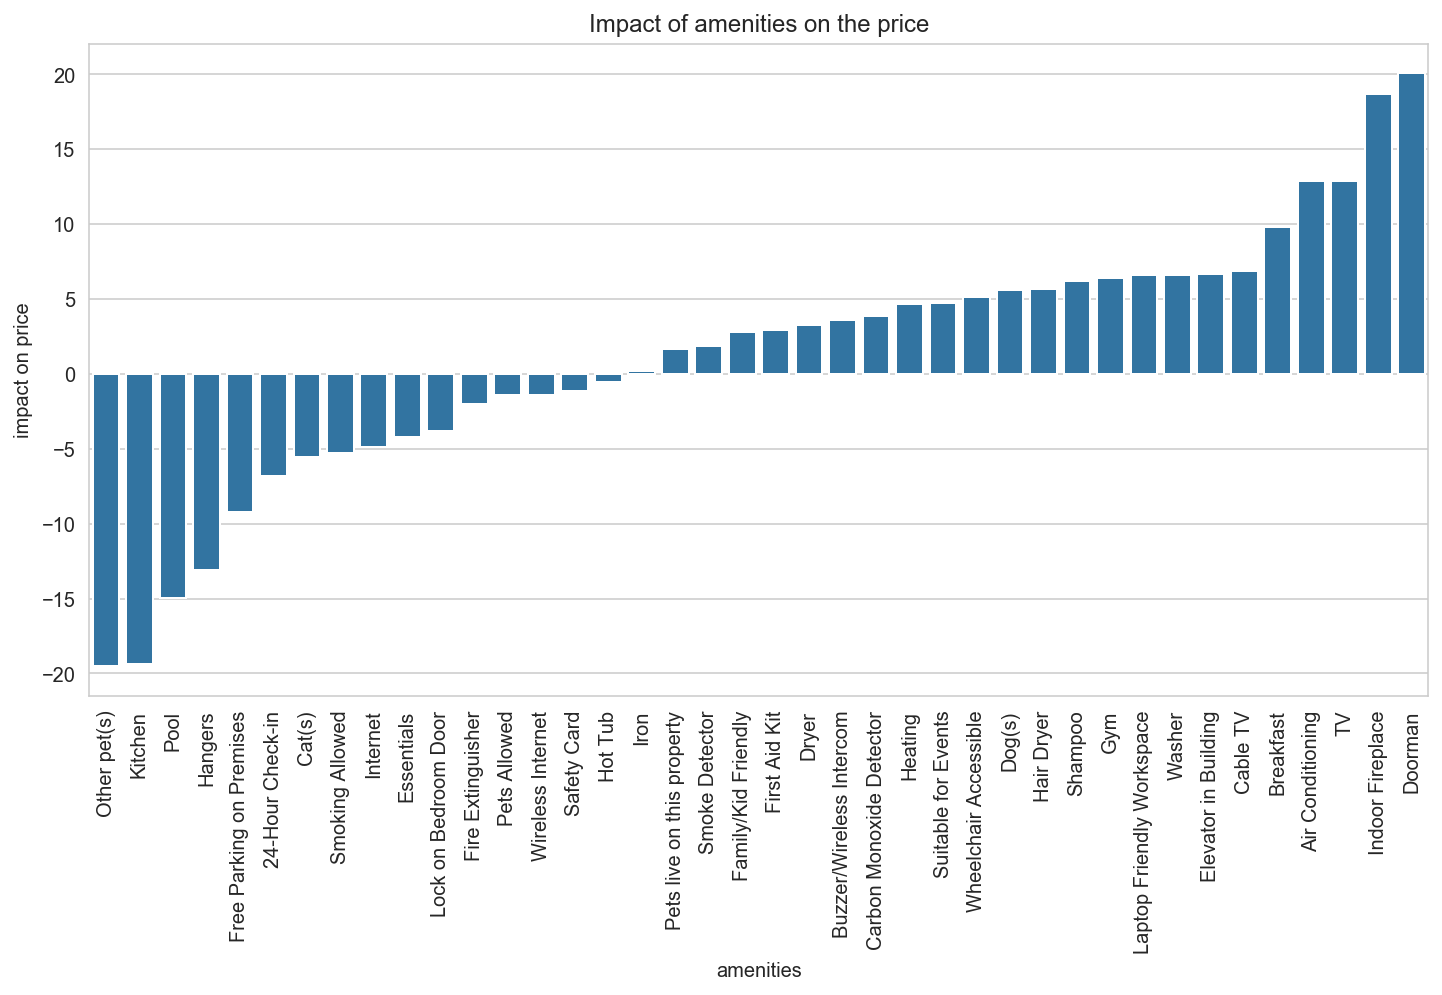

In [165]:
fig = plt.subplots(figsize=(12,6))
sns.barplot(x=amenity_coeff.index, y=amenity_coeff['coefficients'], order=amenity_coeff.sort_values('coefficients').index,
           color=b_color)
plt.xticks(rotation='vertical')
plt.title('Impact of amenities on the price')
plt.ylabel('impact on price')
plt.xlabel('amenities')
plt.savefig('Pictures/amenities.png', dpi=200, bbox_inches='tight');

In [158]:
data = amenity_dummy.sum().values
index = amenity_dummy.sum().index

In [161]:
amenity_sum = pd.DataFrame(data, index)
amenity_sum.rename(columns={0: 'sum'}, inplace=True)

Text(0.5, 0, 'amenities')

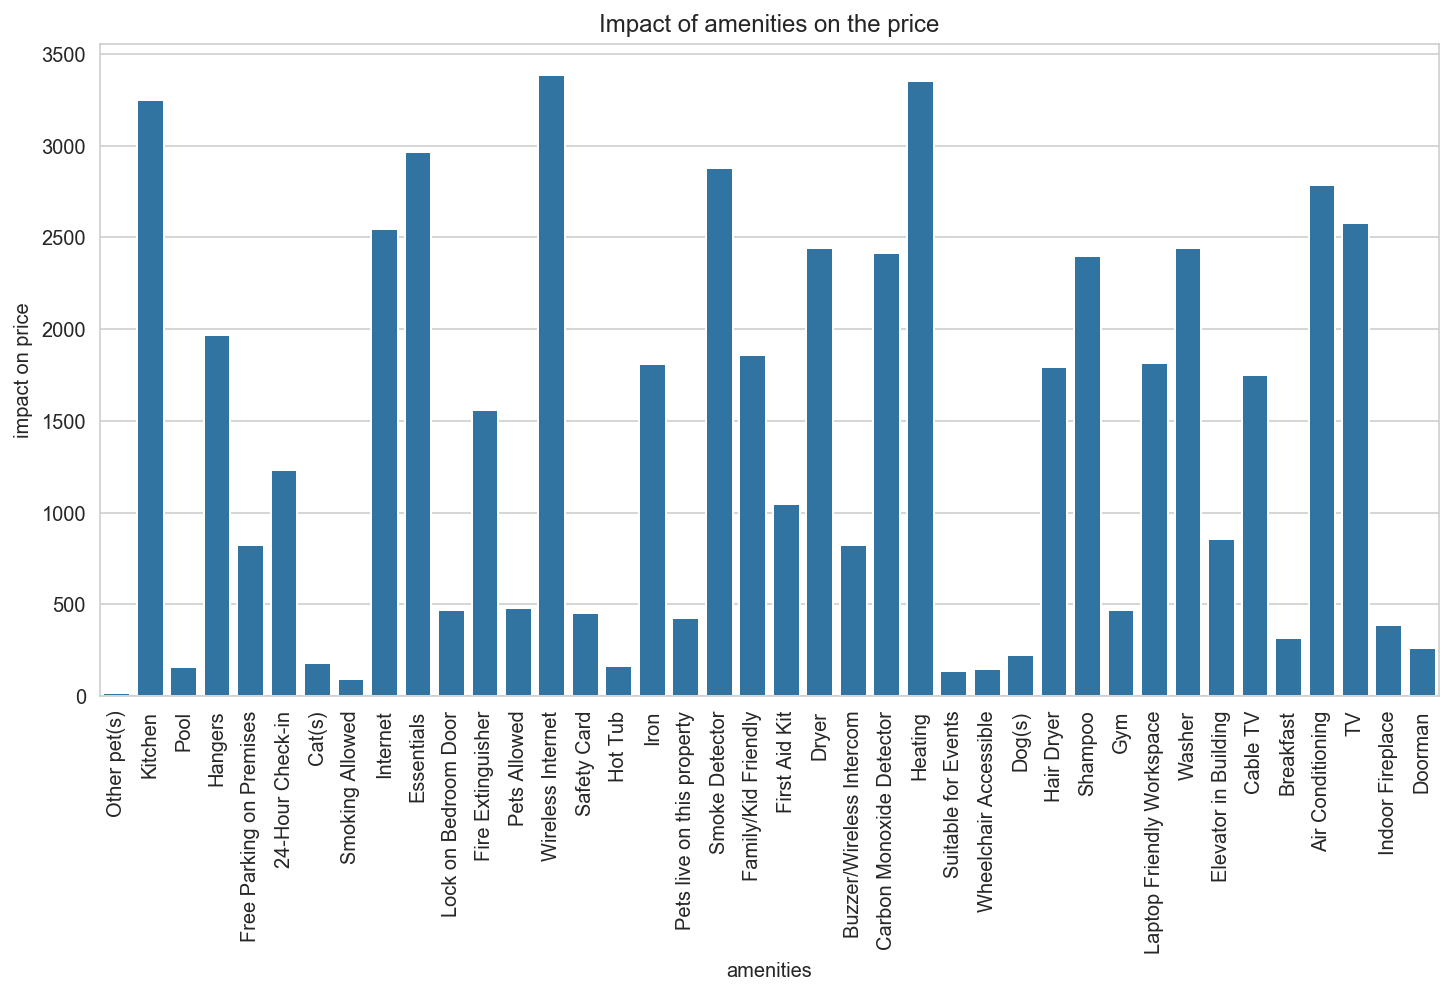

In [166]:
fig = plt.subplots(figsize=(12,6))
sns.barplot(x=amenity_sum.index, y=amenity_sum['sum'], order=amenity_coeff.sort_values('coefficients').index,
           color=b_color)
plt.xticks(rotation='vertical')
plt.title('Impact of amenities on the price')
plt.ylabel('impact on price')
plt.xlabel('amenities')
#plt.savefig('Pictures/amenities.png', dpi=200);

<a id='resources'></a>
### Resources
- https://matplotlib.org/gallery/api/two_scales.html
- https://plotly.com/python/mapbox-layers/
- https://medium.com/analytics-vidhya/plotly-for-geomaps-bb75d1de189f
- https://towardsdatascience.com/how-to-create-a-plotly-visualization-and-embed-it-on-websites-517c1a78568b
- https://towardsdatascience.com/8-clutch-ways-to-impute-missing-data-690481c6cb2b
- https://stackoverflow.com/questions/36413314/filling-missing-data-by-random-choosing-from-non-missing-values-in-pandas-datafr
- https://www.kaggle.com/residentmario/modeling-prices